## Predict demographic and behavioral measures from connectomes
* Fit a linear model to training data to predict age, sex, cognitive score, etc...
* Inputs can be measured connectomes, predicted connectomes, or Krakencoder latent representations
* Each model is computed and predictions are saved to a separate CSV file, so we can compare results after
* Compare prediction accuracy between different models, with permutation significance test and multiple comparisons correction
    * Bootstrap samples are matched across models, to allow pairwise comparison
* Create bar plots for prediction accuracy with bootstrap confidence interval whiskers and significance markers

In [2]:
from IPython import get_ipython

import os
import pandas as pd

from utils import timestamp, krakendir
from data import load_study_data, parse_data_spec

from predict import *
from plotting import *

output_dir=krakendir()+'/demographic_prediction_figures'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir,exist_ok=True)

In [3]:
# Run demographic prediction models and save results to csv file
# We make a separate CSV file for each input type (eg: latent or raw), and combine these latter for plotting and comparison

timestamp_str=timestamp()

    
# Load the data
demo_var_list=['Sex','Age','nih_totalcogcomp_ageadjusted','nih_fluidcogcomp_ageadjusted','nih_crycogcomp_ageadjusted','nih_eccogcomp_ageadjusted']

xtype_all=['enc_mean','enc_FCmean','enc_SCmean','enc_FCSCmean','enc_FCSCcat']


whichstudy='HCP' #or 'HCPA', 'HCPD'

exclude_str=None
data_sex_filter=None
data_age_range=None


#latent_or_raw_list=["latent=corr","raw=corr"]
#latent_or_raw_list=["latent=corr.post","raw=corr"]
latent_or_raw_list=["latent","raw=cosine"]

for latent_or_raw_spec in latent_or_raw_list:
    print("Running %s" % (latent_or_raw_spec))
    Data = load_study_data(whichstudy,combine_type='mean',latent_or_raw_spec=latent_or_raw_spec, exclude_flavor_string=exclude_str, 
                        sex_filter=data_sex_filter, age_range=data_age_range)

    # Fit the prediction model

    do_plot_prediction=False
    do_print_prediction=False

    residualize_names=[]
    residualize_age=True
    residualize_sex=True

    #resample_loops=2 #testing
    resample_loops=100 #production
    
    randseed_base=0
    cvnum=10 #how many inner loops for each CV gridsearch
    gridloops=3 #how many depths to repeat the iterative gridsearch
    df_performance = fit_prediction_model(Data, demo_var_list, xtype_all, cvnum=cvnum, gridloops=gridloops, resample_loops=resample_loops, randseed_base=randseed_base, 
                                    print_prediction=do_print_prediction, plot_prediction=do_plot_prediction, include_predicted_and_true_in_output=True,
                                    residualize_names=residualize_names, residualize_age=residualize_age, residualize_sex=residualize_sex)

    ### save prediction performance to csv file for comparison and plotting
    numflav=15
    if exclude_str == 'pcorr':
        numflav=12
    elif exclude_str == 'gsr':
        numflav=12
    datastr='%dflav' % (numflav)
    if len(xtype_all)>4:
        datastr+="_%dinputs" % (len(xtype_all))
    latentdata_sim, rawdata_sim, prediction_sim = parse_data_spec(latent_or_raw_spec)
    if rawdata_sim:
        datastr+='_rawcosinesim'
    if latentdata_sim:
        datastr+='_encavgsim'

    #output_filename="performance_%s_resample%d_%%T" % (whichstudy,max(df_performance_toplot['resample'])+1)
    output_filename=os.path.join(output_dir, "performance_%s_%s_resample%d_%s.csv" % (whichstudy,datastr,resample_loops,timestamp_str))

    df_performance.to_csv(output_filename,index=False)
    print("Saved %s" % (output_filename))

Running latent


  0%|          | 0/2 [00:00<?, ?it/s]

Saved /Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_5inputs_resample2_20240506-152918.csv
Running raw=cosine


  0%|          | 0/2 [00:00<?, ?it/s]

Saved /Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_5inputs_rawcosinesim_resample2_20240506-152918.csv


         0          0       0.02 nih_eccogcomp_ageadjusted enc_SCmean enc raw
   0.00910000 0.00910000 enc Sex enc_FCmean enc_FCmean
   0.00000000 0.00000000 enc Sex enc_SCmean enc_SCmean
   0.00070000 0.00074118 enc Sex enc_FCSCmean enc_FCSCmean
   0.00000000 0.00000000 enc Age enc_FCmean enc_FCmean
   0.00000000 0.00000000 enc Age enc_SCmean enc_SCmean
   0.00000000 0.00000000 enc Age enc_FCSCmean enc_FCSCmean
   0.00000000 0.00000000 enc nih_totalcogcomp_ageadjusted enc_FCmean enc_FCmean
   0.00000000 0.00000000 enc nih_totalcogcomp_ageadjusted enc_SCmean enc_SCmean
   0.00000000 0.00000000 enc nih_totalcogcomp_ageadjusted enc_FCSCmean enc_FCSCmean
   0.00000000 0.00000000 enc nih_fluidcogcomp_ageadjusted enc_FCmean enc_FCmean
   0.00000000 0.00000000 enc nih_fluidcogcomp_ageadjusted enc_SCmean enc_SCmean
   0.00000000 0.00000000 enc nih_fluidcogcomp_ageadjusted enc_FCSCmean enc_FCSCmean
   0.00000000 0.00000000 enc nih_crycogcomp_ageadjusted enc_FCmean enc_FCmean
   0.00000000 0.00

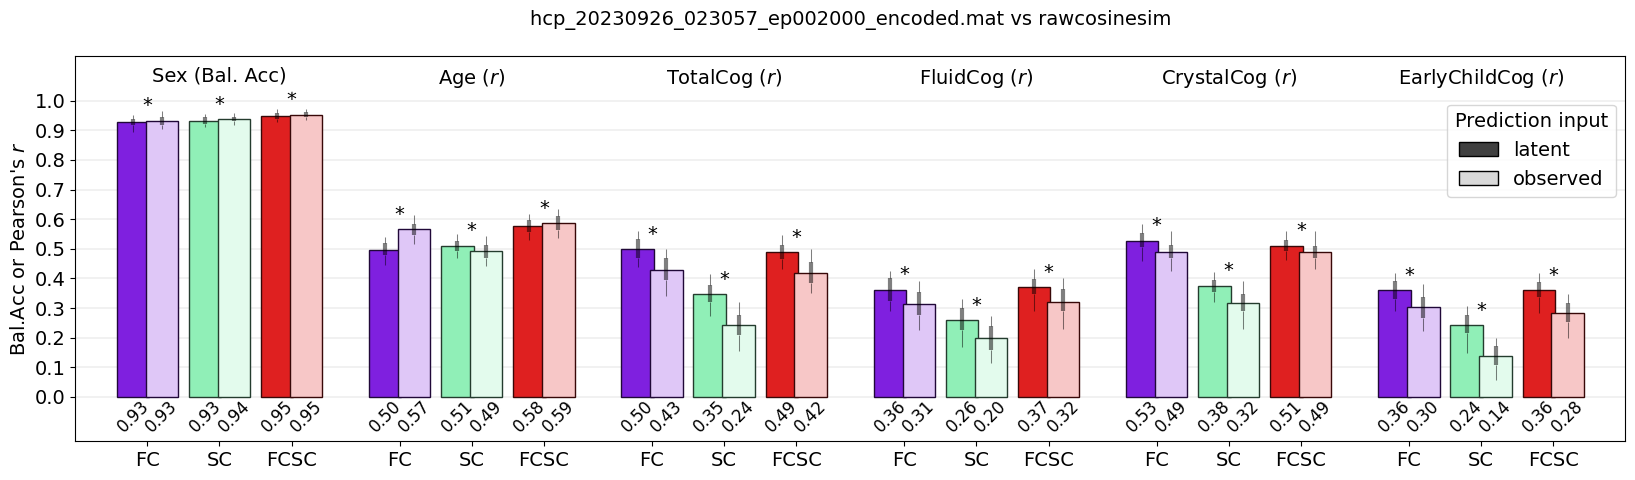

In [7]:
# plot results

whichstudy='HCP'


demo_var_list=['Sex','Age','nih_totalcogcomp_ageadjusted','nih_fluidcogcomp_ageadjusted','nih_crycogcomp_ageadjusted','nih_eccogcomp_ageadjusted']
xtype_all=['enc_FCmean','enc_SCmean','enc_FCSCmean']

exclude_str=None
latent_or_raw_spec='latent' #could be 'latent' (for 128dim), 'raw' (same as raw=cosine, subj x subj), 'latent=corr' (for subj x subj), 'raw=corr' (subj x subj)
data_sex_filter=None
data_age_range=None
Data = load_study_data(studyname=whichstudy,combine_type='mean', 
                        latent_or_raw_spec=latent_or_raw_spec,
                        exclude_flavor_string=exclude_str, 
                        sex_filter=data_sex_filter, age_range=data_age_range) #for latent (note: still includes enc_cat)
    
#HCP latent vs raw
df_performance_list=[]

#df_performance_list.append(pd.read_csv('/Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_resample100_20231108-145543.csv')) #orig fusion
#df_performance_list[-1]['study']='HCP'
#df_performance_list[-1]['dataname']='enc'

#mse.w1000 fusion
df_performance_list.append(pd.read_csv('/Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_mse.w1000_resample100_20240109-111002.csv'))
df_performance_list[-1]['study']='HCP'
df_performance_list[-1]['dataname']='enc'

## these are the predictions based on averaging the 15 latent subject simliarity matrices
#df_performance_list.append(pd.read_csv('/Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_resample100_20240318-095158.csv'))
#df_performance_list[-1]['study']='HCP'
#df_performance_list[-1]['dataname']='encavgsim'
#df_performance_list[-1]['dataname']='enc'

#these are the average of 15 predictions
#df_performance_list.append(pd.read_csv('/Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_15inputs_resample100_20240315-201704_post.csv'))
#df_performance_list[-1]['study']='HCP'
#df_performance_list[-1]['dataname']='enc15pred'

df_performance_list.append(pd.read_csv('/Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_rawcosinesim_resample100_20231108-145543.csv'))
df_performance_list[-1]['study']='HCP'
#df_performance_list[-1]['dataname']='rawavgsim'
df_performance_list[-1]['dataname']='raw'

#df_performance_list.append(pd.read_csv('/Users/kwj5/Research/krakencoder/demographic_prediction_figures/performance_HCP_15flav_15inputs_rawcosinesim_resample100_20240316-085338_post.csv'))
#df_performance_list[-1]['study']='HCP'
#df_performance_list[-1]['dataname']='raw15pred'



#df_performance_toplot=pd.concat((df_performance1,df_performance2),ignore_index=True)

df_performance_toplot=pd.concat(df_performance_list, ignore_index=True)

plot_title_override='hcp_20230926_023057_ep002000_encoded.mat vs rawcosinesim'


output_dir=os.path.join(krakendir(),'demographic_prediction_figures')
output_filename="performance_%s_resample%d_%%T" % (whichstudy,max(df_performance_toplot['resample'])+1)
#output_filename="performance_%s_resample%d_%%T" % (whichstudy,len(y_list))

pval_thresh=.01
siglist=prediction_comparison_significance_tests(df_performance=df_performance_toplot, demo_var_list=demo_var_list, input_flavors=xtype_all, 
                                                 permutation_numsamples=10000, permutation_twosided=True)

fig=plot_prediction_barplot(df_performance_toplot, demo_var_list=demo_var_list, input_flavors=xtype_all, siglist=siglist, pval_thresh=pval_thresh,
                             enc_is_cosinesim=Data['enc_is_cosinesim'], enc_is_pc=Data['enc_is_pc'], 
                             rawdata='dataname' in df_performance_toplot and len(np.unique(df_performance_toplot['dataname']))>1, 
                             plottitle=plot_title_override, figdpi=100,
                             output_file=None)


if get_ipython():
    #### add some widgets to allow easy saving of result csv and png
    add_save_buttons(output_dir,output_filename,fig,df_performance_toplot)
